
## **Basketball Shot Predictions** 🏀
Lets have some fun

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score , RandomizedSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

from sklearn import datasets, metrics
from sklearn.metrics import accuracy_score

# Wrangling In Data



In [5]:
# imported dataframe and parsed dates for game_date an set as index
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url, parse_dates=['game_date'], index_col='game_date')

df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot
game_date,,,,,,,,,,,,,,,,,,,
2009-10-28,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,GSW,HOU,Regular Season,2.0
2009-10-28,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,GSW,HOU,Regular Season,0.0
2009-10-28,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,GSW,HOU,Regular Season,-4.0
2009-10-28,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,GSW,HOU,Regular Season,-4.0
2009-10-28,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,GSW,HOU,Regular Season,0.0


In [6]:
type(df.index)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13958 entries, 2009-10-28 to 2019-06-05
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   game_id                  13958 non-null  int64  
 1   game_event_id            13958 non-null  int64  
 2   player_name              13958 non-null  object 
 3   period                   13958 non-null  int64  
 4   minutes_remaining        13958 non-null  int64  
 5   seconds_remaining        13958 non-null  int64  
 6   action_type              13958 non-null  object 
 7   shot_type                13958 non-null  object 
 8   shot_zone_basic          13958 non-null  object 
 9   shot_zone_area           13958 non-null  object 
 10  shot_zone_range          13958 non-null  object 
 11  shot_distance            13958 non-null  int64  
 12  loc_x                    13958 non-null  int64  
 13  loc_y                    13958 non-null  int64  
 14  shot_

# Engineering at 3 new features.

Creating new columns with data from combined columns or redefinning them for a better statistcal approach.

In [7]:

#feature 1
df['sec_left_in_period'] = (df['minutes_remaining'] *60) + df['seconds_remaining']

#feature 2
field_goal = ['2PT Field Goal','3PT Field Goal']
for f in field_goal:
  df[f] = df['shot_type'].str.contains(f).astype(int)

#feature 3
df['total_time_left_in_sec'] = (((4 - df['period']) * 12) * 60) + df['seconds_remaining']

In [ ]:
# Once what type of field goal was understood we drop the duplicate data.
df = df.drop(columns = ['shot_type'])

# Will get an error if ran again due to the df already had the column dropped

In [9]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_zone_basic,shot_zone_area,shot_zone_range,...,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot,sec_left_in_period,2PT Field Goal,3PT Field Goal,total_time_left_in_sec
game_date,,,,,,,,,,,,,,,,,,,,,
2009-10-28,20900015,4,Stephen Curry,1,11,25,Jump Shot,Above the Break 3,Right Side Center(RC),24+ ft.,...,249,0,GSW,HOU,Regular Season,2.0,685,0,1,2185
2009-10-28,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,Mid-Range,Left Side Center(LC),16-24 ft.,...,145,1,GSW,HOU,Regular Season,0.0,571,1,0,2191
2009-10-28,20900015,53,Stephen Curry,1,6,2,Jump Shot,In The Paint (Non-RA),Center(C),8-16 ft.,...,129,0,GSW,HOU,Regular Season,-4.0,362,1,0,2162
2009-10-28,20900015,141,Stephen Curry,2,9,49,Jump Shot,Mid-Range,Left Side(L),16-24 ft.,...,82,0,GSW,HOU,Regular Season,-4.0,589,1,0,1489
2009-10-28,20900015,249,Stephen Curry,2,2,19,Jump Shot,Mid-Range,Left Side Center(LC),16-24 ft.,...,148,0,GSW,HOU,Regular Season,0.0,139,1,0,1459


In [12]:
# Taking a look at points made between the season and playoffs
df['season_type'].value_counts()

Regular Season    11846
Playoffs           2112
Name: season_type, dtype: int64

# Spliting Data
Testing time

In [13]:

target = 'shot_made_flag'
X = df.drop(columns=target)
y = df[target]

# Dividing the dataset into training, validation, and test sets.

Training set contains games from the 2009-10 season through the end of the 2016-17 season.

Validation set contains games from the 2017-18 season.

Test set contains games from the 2018-2019 season.

Reminder - **The NBA season begins in October and ends in June.**

In [15]:

mask = X.index < '2017-07'
mask_2 = (X.index > '2017-09') & (X.index <= '2018-07')
mask_3 = (X.index > '2018-09') & (X.index <= '2019-07')
# Trainning set
X_train, y_train = X.loc[mask], y.loc[mask]
# Validation set
X_val , y_val = X.loc[mask_2], y.loc[mask_2]
# Test set
X_test, y_test = X.loc[mask_3], y.loc[mask_3]

# Establishing a Baseline



In [19]:
# Starting point for comparison purposes
baseline_acc = y_train.value_counts(normalize = True).max()
print('Baseline Accuracy:', baseline_acc)

Baseline Accuracy: 0.5272087356736757


# Build Model

I will build a model that includes 1 transformer for categorical features and 2 tree-based predictors.

In [20]:

model = make_pipeline(OrdinalEncoder(), SimpleImputer(), RandomForestClassifier(n_estimators = 100, max_depth= 20))
model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['player_name', 'action_type',
                                      'shot_zone_basic', 'shot_zone_area',
                                      'shot_zone_range', 'htm', 'vtm',
                                      'season_type'],
                                mapping=[{'col': 'player_name',
                                          'data_type': dtype('O'),
                                          'mapping': Stephen Curry    1
NaN             -2
dtype: int64},
                                         {'col': 'action_type',
                                          'data_type': dtype('O'),
                                          'mapping': Jump Shot                              1
Step Back Jump shot                    2
Pullup Jump sho...
MIN     5
POR     6
LAL     7
IND     8
ORL     9
SAS    10
WAS    11
PHX    12
BOS    13
SAC    14
CLE    15
MIA    16
MIL    17
CHI    18
DEN    19
NJN    20
NOH    21
CHA    22
OKC    23
DAL    24
UTA    25
ATL    26
PHI    27
DET    28
TOR    29
NYK    30
BKN    31
NOP    32
NaN    -2
dtype: int64},
                                         {'col': 'season_type',
                                          'data_type': dtype('O'),
                                          'mapping': Regular Season    1
Playoffs          2
NaN              -2
dtype: int64}])),
                ('simpleimputer', SimpleImputer()),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=20))])

# Checking the Metrics

Checking the training and validation accuracy of the model, and assign the scores to `train_acc` and `val_acc` respectively.

In [24]:
train_acc = model.score(X_train, y_train)
val_acc = model.score(X_val, y_val)

# Training Accu is higher than the validation
print('Training Accuracy Score:', train_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.9980146196191679
Validation Accuracy Score: 0.598458904109589


# Tune Model

Testing out the test accuracy

In [25]:
test_acc = model.score(X_test, y_test)
print('Testing Accuracy Score:', test_acc)

Testing Accuracy Score: 0.6243417203042715


# Communication

Putting together data for a confusion matrix from the model.


In [27]:
#Precision = TP / (TP + FP)
#Recall = TP / (TP + FN)

In [29]:
instructor_precision = 538 / (538 + 387)
instructor_recall = 538 / (538 + 259)
print('Instuctor model precision', instructor_precision)
print('Instuctor model recall', instructor_recall)

Instuctor model precision 0.5816216216216217
Instuctor model recall 0.6750313676286073


# Plotting confusion matrix for the model using the **test data**.



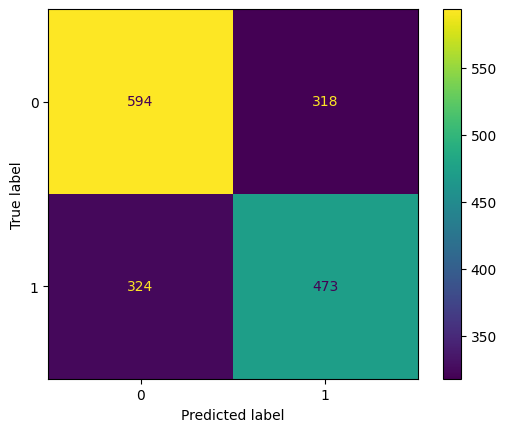

In [34]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

In [35]:
y_pred = model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.65      0.65       912
           1       0.60      0.59      0.60       797

    accuracy                           0.62      1709
   macro avg       0.62      0.62      0.62      1709
weighted avg       0.62      0.62      0.62      1709



In [36]:
report = metrics.classification_report(y_test, y_pred, output_dict=True)
report

{'0': {'precision': 0.6470588235294118,
  'recall': 0.6513157894736842,
  'f1-score': 0.6491803278688524,
  'support': 912.0},
 '1': {'precision': 0.5979772439949431,
  'recall': 0.5934755332496863,
  'f1-score': 0.5957178841309824,
  'support': 797.0},
 'accuracy': 0.6243417203042715,
 'macro avg': {'precision': 0.6225180337621774,
  'recall': 0.6223956613616852,
  'f1-score': 0.6224491059999173,
  'support': 1709.0},
 'weighted avg': {'precision': 0.6241694034656485,
  'recall': 0.6243417203042715,
  'f1-score': 0.6242478716610803,
  'support': 1709.0}}